In [26]:
import pandas as pd
import talib
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import iisignature
from tqdm import tqdm  # For progress bar
from features import construct_features
from signature_feature import create_signature_features 
from sklearn.preprocessing import StandardScaler


In [27]:
btc_df = pd.read_csv('BTCUSDC-1m-2years.csv') 

In [28]:
def resample(df, resample_freq = '15min'):
    prices = pd.DataFrame()
    prices['close'] = df.close.resample(resample_freq).last()
    prices['open'] = df.open.resample(resample_freq).first()
    prices['high'] = df.high.resample(resample_freq).max()
    prices['low'] = df.low.resample(resample_freq).min()
    prices['volume'] = df.volume.resample(resample_freq).sum()
    prices['quote_asset_volume'] = df.quote_asset_volume.resample(resample_freq).sum()
    prices['taker_buy_base_volume'] = df.taker_buy_base_volume.resample(resample_freq).sum()
    prices['taker_buy_quote_volume'] = df.taker_buy_quote_volume.resample(resample_freq).sum()
    prices['number_of_trades'] = df.number_of_trades.resample(resample_freq).sum()
    return prices

In [29]:
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'],dayfirst=True )
btc_df.set_index('timestamp', inplace=True)

In [30]:
btc_df = resample(btc_df)

In [31]:
btc_df

,close,open,high,low,volume,quote_asset_volume,taker_buy_base_volume,taker_buy_quote_volume,number_of_trades
timestamp,,,,,,,,,
2024-01-01 00:00:00,42476.73,42274.27,42476.73,42255.49,12.31433,5.221436e+05,9.11650,3.865379e+05,305
2024-01-01 00:15:00,42409.47,42476.72,42538.32,42401.10,9.55929,4.059740e+05,6.15720,2.614881e+05,224
2024-01-01 00:30:00,42426.50,42397.18,42434.35,42344.56,6.02744,2.555086e+05,2.59424,1.099456e+05,142
2024-01-01 00:45:00,42465.40,42430.75,42481.42,42408.39,3.41888,1.451412e+05,1.82568,7.749070e+04,84
2024-01-01 01:00:00,42458.23,42455.15,42460.30,42418.66,4.66731,1.980668e+05,3.18827,1.352952e+05,137
...,...,...,...,...,...,...,...,...,...
2025-09-30 22:45:00,113992.02,113968.08,114080.27,113961.01,18.02007,2.054504e+06,12.02029,1.370441e+06,3326
2025-09-30 23:00:00,113883.76,113990.80,114000.39,113766.63,51.76906,5.895316e+06,20.98677,2.389888e+06,3960
2025-09-30 23:15:00,114013.00,113886.31,114063.79,113817.89,22.08340,2.515980e+06,11.83615,1.348476e+06,2376


In [32]:
new_df = construct_features(btc_df)
sig_features = create_signature_features(btc_df, window_size=100, level=2)

new_df = pd.concat([new_df, sig_features], axis=1)

Computing Rolling Signatures (Window: 100, Level: 2)...


100%|██████████| 61244/61244 [00:00<00:00, 273960.69it/s]


In [33]:
new_df = new_df.drop(columns=['Sig_0','Sig_2']) #drop constant features see report for explanation  

In [34]:
print(new_df.head())
new_df.columns.to_list()

                     open_lag_1  high_lag_1  low_lag_1  close_lag_1  \
timestamp                                                             
2024-01-01 00:00:00         NaN         NaN        NaN          NaN   
2024-01-01 00:15:00    42274.27    42476.73   42255.49     42476.73   
2024-01-01 00:30:00    42476.72    42538.32   42401.10     42409.47   
2024-01-01 00:45:00    42397.18    42434.35   42344.56     42426.50   
2024-01-01 01:00:00    42430.75    42481.42   42408.39     42465.40   

                     number_of_trades_lag_1  quote_asset_volume_lag_1  \
timestamp                                                               
2024-01-01 00:00:00                     NaN                       NaN   
2024-01-01 00:15:00                   305.0             522143.612629   
2024-01-01 00:30:00                   224.0             405974.028840   
2024-01-01 00:45:00                   142.0             255508.580710   
2024-01-01 01:00:00                    84.0             145141.1

['open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'close_lag_1',
 'number_of_trades_lag_1',
 'quote_asset_volume_lag_1',
 'taker_buy_quote_volume_lag_1',
 'volume_lag_1',
 'HminusL',
 'return_lag_1',
 'return_lag_2',
 'return_lag_3',
 'return_lag_4',
 'return_lag_5',
 'SMA',
 'correlation_sma_close',
 'sum3',
 'sum5',
 'sum3-sum5',
 'target',
 'RSI9',
 'RSI14',
 'RSI9Smaller20',
 'RSI14Smaller20',
 'RSI9Bigger80',
 'MACD1',
 'MACD2',
 'MACD3',
 'roc9',
 'roc14',
 'ewa',
 'mom5',
 'WilliamR',
 'doubleEMA',
 'ATR5',
 'ATR10',
 'aroon_stoch_k',
 'aroon_stoch_d',
 'Sig_1',
 'Sig_3',
 'Sig_4',
 'Sig_5']

In [35]:
new_df.dropna(inplace=True)

In [36]:
Y = new_df['target']
X = new_df.drop(columns = 'target')

In [37]:
from scipy import stats

corr = pd.DataFrame()
corr.index = X.columns
for col in X.columns:
    st = stats.pearsonr(X[col], Y)
    corr.loc[col, 'corr'] = st.statistic
    corr.loc[col, 'pvalue'] = st.pvalue

corr.sort_values(key = lambda x: np.abs(x), by='corr', ascending=False)

,corr,pvalue
RSI9,-0.062507,4.468729e-54
WilliamR,0.058098,6.010041e-47
RSI14,-0.057811,1.680325e-46
sum3,-0.047542,5.456317e-32
sum5,-0.041847,3.752346e-25
mom5,-0.040990,3.376228e-24
MACD3,-0.039893,5.280693e-23
return_lag_1,-0.038897,5.996037e-22
roc9,-0.036506,1.606838e-19
MACD1,-0.032821,4.498115e-16


In [38]:
length = len(btc_df)
print(length)

61344


In [39]:
n1 = int(len(X) * 0.8)
n2 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_eval, y_eval = X[n1:n2], Y[n1:n2]
X_test, y_test = X[n2:], Y[n2:]

In [40]:
sum(y_test==0)/len(y_test)

0.5012244897959184

In [41]:
params={'learning_rate': 0.001,
        'max_depth': 8,
        'n_jobs': -1,
        'early_stopping_round':500,
        'random_state':42,
        'n_estimators':10000,
        'max_depth':64,
        #'objective': 'accuracy',
        'feature_fraction':0.5,
        #'reg_alpha':100,
        #'max_depth':-1,
        #'reg_lambda':1,
        #'lambda_l2':3.0,        
        #'lambda_l1':0.5,
        'bagging_fraction':0.5,
        'bagging_freq':2,
        'min_data_in_leaf': 20
        #'boosting_type':''
        }
LGBMmodel=LGBMClassifier(**params)
        
LGBMmodel.fit(X_train, y_train, eval_set=[(X_eval, y_eval)])

y_pred = LGBMmodel.predict(X_test)
        
print("LGBM Accuracy: ",accuracy_score(y_test, y_pred))

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 24601, number of neg

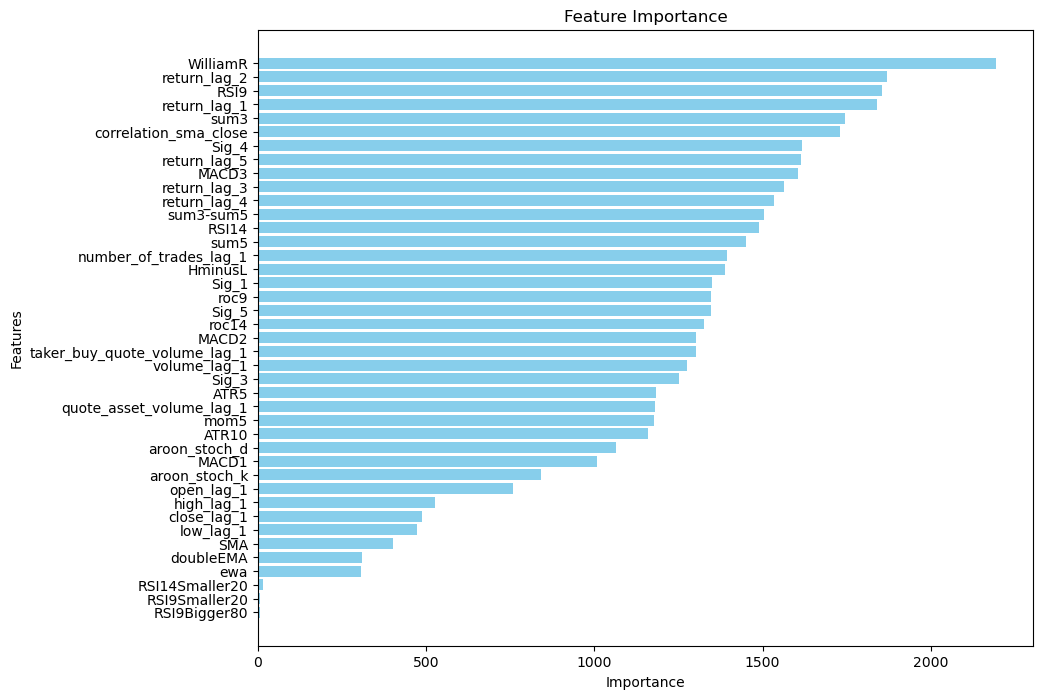

In [42]:
import matplotlib.pyplot as plt

# Extract feature importance from the LightGBM model
feature_importances = LGBMmodel.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Neural Network

In [43]:
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
import torch

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

model= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                scheduler_params={"step_size":10, 
                                    "gamma":0.9},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                )
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_eval_scaled, y_eval)],
    eval_name=['train', 'validation'],
    eval_metric=['accuracy'],
    max_epochs=500, patience=80,
    batch_size=512, virtual_batch_size=512,
    drop_last=False
)            

X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)
score = accuracy_score(y_test, y_pred)    
print(f"TabNet Score: {score:0.3f}")
#print(f"TabNet OOF Score: {accuracy_score(Y, oof)}")


/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7074  | train_accuracy: 0.52099 | validation_accuracy: 0.52188 |  0:00:04s
epoch 1  | loss: 0.69385 | train_accuracy: 0.52213 | validation_accuracy: 0.51404 |  0:00:11s
epoch 2  | loss: 0.6926  | train_accuracy: 0.52358 | validation_accuracy: 0.51306 |  0:00:20s
epoch 3  | loss: 0.69173 | train_accuracy: 0.52091 | validation_accuracy: 0.51306 |  0:00:26s
epoch 4  | loss: 0.69136 | train_accuracy: 0.52542 | validation_accuracy: 0.516   |  0:00:32s
epoch 5  | loss: 0.69104 | train_accuracy: 0.5234  | validation_accuracy: 0.52008 |  0:00:36s
epoch 6  | loss: 0.69148 | train_accuracy: 0.52399 | validation_accuracy: 0.52008 |  0:00:41s
epoch 7  | loss: 0.69131 | train_accuracy: 0.52611 | validation_accuracy: 0.52106 |  0:00:45s
epoch 8  | loss: 0.69114 | train_accuracy: 0.52393 | validation_accuracy: 0.51633 |  0:00:49s
epoch 9  | loss: 0.69102 | train_accuracy: 0.52744 | validation_accuracy: 0.51911 |  0:00:54s
epoch 10 | loss: 0.69101 | train_accuracy: 0.5246  | validat

/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Score: 0.524


## Logistic Regression

In [45]:
n1 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_test, y_test = X[n1:], Y[n1:]

from sklearn.linear_model import LogisticRegressionCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=5000)#), penalty='l1', solver='liblinear')

print("Training model and tuning C...")
clf.fit(X_train_scaled, y_train)

optimal_c = clf.C_[0]

print("-" * 30)
print(f"Optimal C value found: {optimal_c:.4f}")
print("-" * 30)

y_pred = clf.predict(X_test_scaled)
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")



Training model and tuning C...
------------------------------
Optimal C value found: 0.0001
------------------------------
Test Set Accuracy: 0.5200
